In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn.preprocessing import PolynomialFeatures

In [28]:
folder_dir = '../data/'
date_range = ["2012","2013","2014","2015","2016","2017"]

In [29]:
for i in range(len(date_range)):
    year = date_range[i]
    data_path = "MLB_" + year + "/MLB_PitchFX_" + year + "_RegularSeason.csv"
    year_data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
    
    if i == 0:
        data = year_data
    else:
        data = pd.concat([data,year_data])

data.head()

,date,stadium,inning,side,pitcher,pitch_count,batter,balls,strikes,ay,...,break_length,y,x0,on_1b,on_2b,on_3b,umpcall,outcome,offense_score,defense_score
0,2012-04-04,Marlins Park,1,top,johnsjo09,5,beltrca01,0,0,30.626,...,3.4,154.56,-1.902,NaN,NaN,NaN,X,Single,0,0
1,2012-04-04,Marlins Park,1,top,johnsjo09,6,hollima01,0,0,28.580,...,3.8,132.11,-2.052,beltrca01,NaN,NaN,S,NaN,0,0
2,2012-04-04,Marlins Park,1,top,johnsjo09,7,hollima01,0,1,31.294,...,3.7,125.20,-2.130,beltrca01,NaN,NaN,S,NaN,0,0
3,2012-04-04,Marlins Park,1,top,johnsjo09,8,hollima01,0,2,33.548,...,3.6,151.97,-2.100,beltrca01,NaN,NaN,B,NaN,0,0
4,2012-04-04,Marlins Park,1,top,johnsjo09,9,hollima01,1,2,24.925,...,7.1,144.20,-2.312,beltrca01,NaN,NaN,X,Flyout,0,0


In [30]:
'''
TODO:
    -More exploratory data analysis
    -Feature engineering/Clean data/select features
    -Define target valuable   
    
'''

'\nTODO:\n    -More exploratory data analysis\n    -Feature engineering/Clean data/select features\n    -Define target valuable   \n    \n'

In [31]:
data = data.drop(['on_1b', 'on_2b', "on_3b",'y'], axis = 1)
data.shape

(3902210, 43)

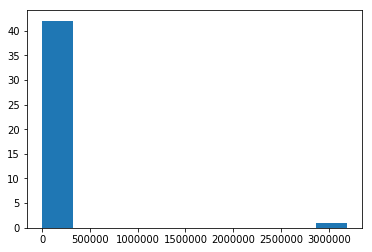

In [32]:
_ = plt.hist(data.isnull().sum())

In [33]:
data.columns.values

array(['date', 'stadium', 'inning', 'side', 'pitcher', 'pitch_count',
       'batter', 'balls', 'strikes', 'ay', 'px', 'ax', 'sz_bot', 'vz0',
       'vy0', 'pfx_x', 'type_confidence', 'z0', 'tfs', 'pz', 'start_speed',
       'az', 'zone', 'break_angle', 'spin_dir', 'end_speed', 'vx0',
       'sz_top', 'nasty', 'descr', 'pfx_z', 'break_y', 'pitch_type',
       'tfs_zulu', 'x', 'spin_rate', 'y0', 'break_length', 'x0', 'umpcall',
       'outcome', 'offense_score', 'defense_score'], dtype=object)

In [34]:
data.isnull().sum()

date                     0
stadium                  0
inning                   0
side                     0
pitcher                313
pitch_count              0
batter                   5
balls                    0
strikes                  0
ay                       0
px                       0
ax                       0
sz_bot                   0
vz0                      0
vy0                      0
pfx_x                    0
type_confidence          0
z0                       0
tfs                     29
pz                       0
start_speed              0
az                       0
zone                     0
break_angle              0
spin_dir                 0
end_speed                0
vx0                      0
sz_top                   0
nasty                  317
descr                    0
pfx_z                    0
break_y                  0
pitch_type               0
tfs_zulu                29
x                        0
spin_rate                0
y0                       0
b

(array([  273908.,   117352.,   197796.,   409078.,   174966.,   199062.,
          181744.,   522515.,   357548.,  1468241.]),
 array([  1. ,   2.3,   3.6,   4.9,   6.2,   7.5,   8.8,  10.1,  11.4,
         12.7,  14. ]),
 <a list of 10 Patch objects>)

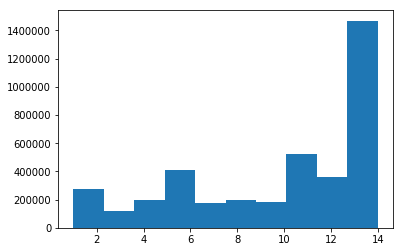

In [35]:
plt.hist(data['zone'])

(array([ 127781.,  222706.,  209657.,  570044.,  554273.,  963124.,
         906232.,  206608.,   76506.,   65279.]),
 array([ -2.00000000e-03,   3.59983000e+01,   7.19986000e+01,
          1.07998900e+02,   1.43999200e+02,   1.79999500e+02,
          2.15999800e+02,   2.52000100e+02,   2.88000400e+02,
          3.24000700e+02,   3.60001000e+02]),
 <a list of 10 Patch objects>)

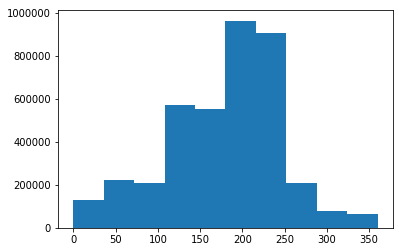

In [36]:
plt.hist(data['spin_dir'])

## 1. Target variable
We classify a pitch as good if it induces a swinging strike, a called strike, a foul, or if it generates a
ball in play that is converted to an out

In [37]:
data.outcome.unique()

array(['Single', nan, 'Flyout', 'Groundout', 'Pop Out', 'Lineout',
       'Sac Bunt', 'Forceout', 'Double Play', 'Grounded Into DP', 'Double',
       'Fielders Choice', 'Field Error', 'Triple', 'Home Run', 'Sac Fly',
       'Fielders Choice Out', 'Bunt Groundout', 'Bunt Pop Out',
       'Fan interference', 'Triple Play', 'Batter Interference',
       'Sac Fly DP', 'Bunt Lineout', 'Catcher Interference',
       'Sacrifice Bunt DP', 'Fly Out', 'Reach on Error',
       'Pitcher Interference'], dtype=object)

In [38]:
data.umpcall.unique()

array(['X', 'S', 'B'], dtype=object)

In [39]:
data.descr.unique()

array(['In play, no out', 'Foul Tip', 'Swinging Strike', 'Ball',
       'In play, out(s)', 'Called Strike', 'In play, run(s)', 'Foul',
       'Foul (Runner Going)', 'Hit By Pitch', 'Ball In Dirt', 'Foul Bunt',
       'Swinging Strike (Blocked)', 'Missed Bunt'], dtype=object)

In [40]:
#Using descr feature to define good pitch
g_outcomes=['Foul Tip','Swinging Strike','In play, out(s)', 'Called Strike', 'Foul','Foul (Runner Going)','Foul Bunt',
       'Swinging Strike (Blocked)', 'Missed Bunt' ]

#Using outcome feature to use more detailed descriptions (eg: lineout vs groundout). I think this approach is better
g_outcomes2=['Flyout', 'Fly Out','Groundout','Pop Out','Forceout','Double Play','Grounded into DP','Fielders Choice','Fielders Choice Out', 
             'Bunt Groundout','Bunt Pop Out','Sac Fly DP','Bunt Lineout','Foul']

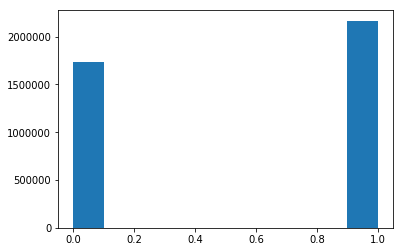

In [41]:
#Create target feature
data['y']=np.where((data['outcome'].isin(g_outcomes2)) | (data['umpcall']=='S'),1,0)
a=plt.hist(data['y'])

In [42]:
data.y.unique(), data.y.isnull().any()

(array([0, 1], dtype=int64), False)

In [43]:
data.columns

Index(['date', 'stadium', 'inning', 'side', 'pitcher', 'pitch_count', 'batter',
       'balls', 'strikes', 'ay', 'px', 'ax', 'sz_bot', 'vz0', 'vy0', 'pfx_x',
       'type_confidence', 'z0', 'tfs', 'pz', 'start_speed', 'az', 'zone',
       'break_angle', 'spin_dir', 'end_speed', 'vx0', 'sz_top', 'nasty',
       'descr', 'pfx_z', 'break_y', 'pitch_type', 'tfs_zulu', 'x', 'spin_rate',
       'y0', 'break_length', 'x0', 'umpcall', 'outcome', 'offense_score',
       'defense_score', 'y'],
      dtype='object')

## 2. Divide in Train (2012-2106) and Test (2017)

In [44]:
#Drop columns we´re not going to use
data['year']=data['date'].str.slice(0,4)

features=['umpcall', 'outcome','start_speed','pfx_x','pfx_z','px','pz','break_y','break_angle','break_length','pitch_type',
         'spin_dir','nasty','pitch_count','descr','y','year','zone','strikes','balls','pitcher','pitch_type']
baseline_features=['start_speed','px','pz','year','y']

data=data[features]
data_base=data[baseline_features]

In [45]:
#data_path = "MLB_" + year + "/MLB_PitchFX_" + year + "_RegularSeason.csv"
#year_data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
save_path=folder_dir+'data_clean.csv'
data.to_csv(save_path) 

In [46]:
#data = data.drop(['on_1b', 'on_2b', "on_3b"], axis = 1)
X_train=data_base[data_base['year']!='2017']
y_train=X_train['y']
X_train=X_train.drop(['y','year'],axis=1)

X_test=data_base[data_base['year']=='2017']
y_test=X_test['y']
X_test=X_test.drop(['y','year'],axis=1)

X_train.head()

,start_speed,px,pz
0,94.9,0.316,2.033
1,92.9,-0.385,3.049
2,93.1,-0.971,3.336
3,92.9,-1.474,2.239
4,88.3,0.247,2.588


In [47]:
X_train.shape

(3186673, 3)

## 3. Baseline with Logistic Regression

In [48]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
poly.fit_transform(X_train)
poly.fit_transform(X_test)

array([[  9.09000000e+01,  -6.36482000e-01,   2.15335000e+00,
         -5.78562138e+01,   1.95739515e+02,  -1.37056851e+00],
       [  9.05000000e+01,   5.40171000e-01,   3.49998000e+00,
          4.88854755e+01,   3.16748190e+02,   1.89058770e+00],
       [  7.52000000e+01,   3.42781000e-01,   1.59708000e+00,
          2.57771312e+01,   1.20100416e+02,   5.47448679e-01],
       ..., 
       [  9.23000000e+01,  -8.53413000e-01,   3.99002000e+00,
         -7.87700199e+01,   3.68278846e+02,  -3.40513494e+00],
       [  8.21000000e+01,  -1.12657000e+00,   2.90930000e+00,
         -9.24913970e+01,   2.38853530e+02,  -3.27753010e+00],
       [  9.21000000e+01,   4.04650000e-01,   1.77480000e+00,
          3.72682650e+01,   1.63459080e+02,   7.18172820e-01]])

In [49]:
X_train.shape, X_test.shape

((3186673, 3), (715537, 3))

In [50]:
baseline=LogisticRegression()
baseline.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [51]:
#print(list(zip(list(X_train.columns),list(baseline.coef_[0]))))
baseline.coef_

array([[-0.00071985,  0.01040999,  0.20208888]])

In [52]:
probs=baseline.predict_proba(X_test)[:,1]
preds=baseline.predict(X_test)
baseline_loss=sklearn.metrics.log_loss(y_test,probs)
baseline_acc=sklearn.metrics.accuracy_score(y_test,preds)
majority_class=np.amax(y_test.value_counts(normalize=True))

print('%s: %0.2f, %s: %0.2f, %s: %0.2f '
      %('Baseline accuracy',baseline_acc,'Baseline log loss', baseline_loss,'Majority class',majority_class))

Baseline accuracy: 0.62, Baseline log loss: 0.68, Majority class: 0.55 
